# Homework 6

## Student: Tyler Lang

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn import tree
from sklearn import ensemble
from sklearn.metrics import accuracy_score
from sklearn.svm import OneClassSVM
from sklearn.model_selection import GridSearchCV
import seaborn as sns

# Problem 1: Conceptual Questions [20 points]

## Part A: 



CART models are classic cases in which model overfitting can become a real concern, and something that has to be actively controlled. This is due to the fact that branching a tree more and more and more will consistently perform better on the training data, and, in the extreme case, we could create a single leaf for each data point, which is the most extreme version of overfitting. Without some type of built in control, it would be difficult to decide the optimal amount of branches and nodes, as the tree building tries to optimize the accuracy on the training data, while not knowing anything about the test data. Thus, how can we control for the data-fit complexity tradeoff? Well, we have a nifty little method, called __pruning!__ First, as we are building the tree, we start with all samples, and node by node, look at remaining nodes and determine if another split can be made along any node (at a specific position). It decides to split if this branching would help in minimizing the total loss of each individual loss function per side of the new branch.

Then, once we grow out our tree to at least a minimum node side, then we can start performing pruning by minimizing the cost of the error in fit, which is penalized by the amount of terminal nodes present. This penalization term is called the regularization parameter.

The equation of this pruning problem can be seen in the lecture slides, which is a minimization problem:

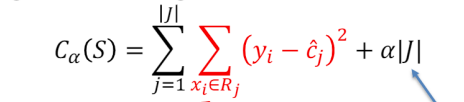

Due to this penalization term, the algorithm then cuts back on nodes if they do not help to minimize this C function, until it finally hits a point in pruning to where pruning more would hurt the model more than it benefits from losing another terminal node. 

## Part B:



Boosting and Bagging are both types of ensemble models, in which we can combine different, very basic models together, and create a more complex model based on their joint outputs. 

The main difference between boosting and bagging is that, in __a boosting model, the result of each iteration is dependent on the previous model's results__ -- For example, in AdaBoost models, certain mathematical equations are used to determine the WEIGHTS that each data point has in determining the stump of the next iteration, which places higher weights on misclassified points, boosting the importance of different harder-to-classify variables over each iteration, which is NOT memoryless (the weight changes in iteration 2 will influence all further iterations -- weights do not reset).  

Whereas, __in a bagging model, many models are created over random partitions or samples of the training data, and the final output of the model is an averaging over all individual weak classifers' output__, like in a standard random forest model. Instead of a boosting model, which is iterative, and with dependence on one iteration to the next, a bagging model uses __bootstrapping__ (sampling from the training set _with replacement_) to create multiple different basic models at once, and then averages over the results. 

The goal of a bagging model is more often to reduce variance, while the goal of a boosting model is more to increase accuracy. Advantages of a bagging model include reducing the possibility of over-fitting, while a disadvantage of boosting models is precisely that they might be more prone to overfitting. 

## Part C:

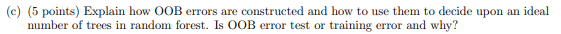

When we run a random forest model, the data that is used to create each basic tree in the forest is dependent on the system of bootstrapping. A common phenomenon we see in statistics is that, when we sample data from a pool, it is much more common to get at least one duplicate point from one sample to another (when we sample with replacement), than it is to get a completely clean sample of points that weren't sampled in iteration 1. Because of this phenomenon, it is a generally accepted fact that most bootstrapping models might omit around 36.8% of the original data pool from the final boostrapped samples, due to sampling duplicate points. When we bootstrap multiple times, another way to view this is to say that, with multiple bootstrapping samples, a particular observation/data point will NOT be contained in approximately 36.8% of the samples. 

While this fact is strange to comprehend, and is a question for staticians, we can use this fact to our advantage! When we run bootstrapping to create a random forest, we are conveniently left with a test data set! 

These points that are "left out" are called **out of the bag**. Thus, these points can be used to assess trees that DO NOT include this particular point in their fitting, and thus it can serve to test model fitness or accuracy. Once we calculate OOB error for each point out of bag, we are replicating a process VERY similar to N-fold cross validation!! In fact, it's the same concept, but just that this data is naturally left out to perform something like cross validation on, and OOB error will often by identical or near-identical to any cross-validation efforts. OOB error is test error, in that it is using a "test set", the OOB set, after the model is already trained, to assess performance. But in reality, it's more like a validation error, as we must still test our final model on new data, as in any pseudo-cross-validation procedure.

Thus, this OOB error can be used to tune the random forest, particularly in deciding the number of trees. As we form trees, as the OOB error stabilizes, then we can stop building the forest and stop the training, having a final model.

## Part D: 



While a standard linear decision boundary model, like linear SVM, assumes data to be linearly separable, in the real world, data is often NOT linearly separable, and might have complex data shapes, in which different points with a specific classification might appear to be intertwined amongst other points with other classifications, or their separability might not form a line. Thus, generally, the idea is that, if we can transform the data into a higher dimension, we could do so in a way that would separate the points. For example, if we had a 2D dataset in which all +1 points were clustered in a circle in the middle, with all -1 points surrounding them in an outer circle, then we could transform the data into a 3D gaussian cone, in which the middle +1 points would rise to the top of the cone, and the -1 points stay below, thus creating a linearly separable space that separates the +1s and the -1s in the 3D space with a linear hyperplane, even if such a thing was not possible in the 2D space. 

However, the problem is that data is also often very high-dimensional. Thus, to have to transform the data into higher dimensions to make it linearly separable could be very computationally costly, as the more features we have, the more polynomial combinations we need to separate the features.

However, we have the __kernel trick__, which allows us to apply a transformation on the data that DOES NOT require putting the data in a higher dimension, yet accomplishes the same goal! 

How does the kernel trick work? Glad you asked! 

The "trick" of it all is that, given a specific kernel method (which must be chosen, and kind of adds to the "magic" of the process, in that it is never obvious or clear which kernel method might work best with high dimensional data), the kernel method transforms the data by taking pairwise dot products among the original data points in a way that transforms them into the SAME DIMENSIONAL SPACE, which gives them the same reduced-dimensional shape that would be accomplished by transforming the data into a higher space, thus (hopefully) making it linearly separable post-transformation! 

Magic or just a cool trick? Take that, Houdini!

# Problem 2: AdaBoost [30 points]

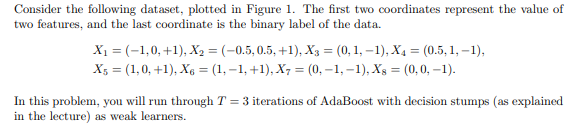

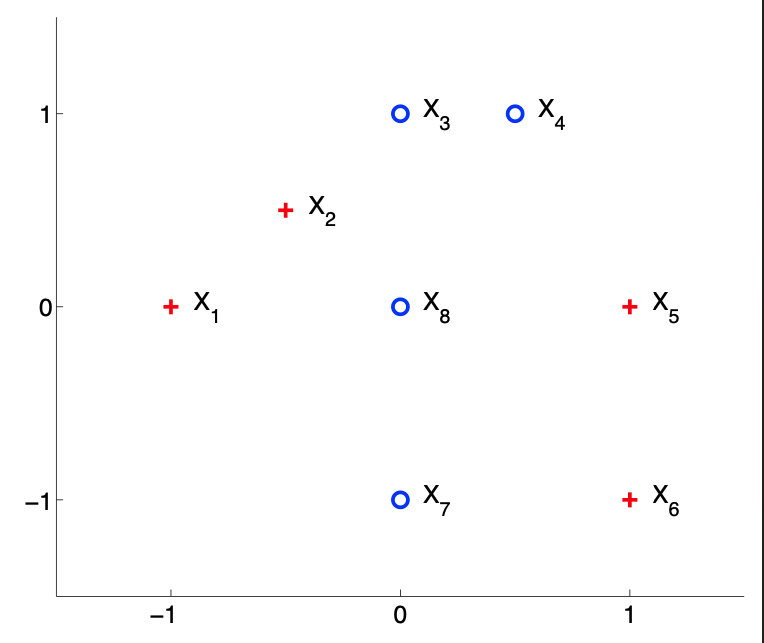

## Part A:

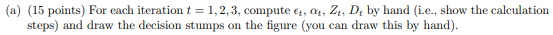

The basic concept of Adaboost is that we will combine various weak learners, which will take the forms of stumps (in this case, horizontal or vertival lines splitting the plane of our data into two for each stump). The way we do so is by first finding the "best stump" that could separate the data into its two classes. Then, we determine the error of such a stump, and weight the misclassified points higher than those classified correclty, so that when creating the second stump, they will be considered more highly, thus making the second stump favor classifying those misclassified points correctly over the points with smaller weights. We repeat this process over several iterations until finally coming to a final solution. In this case, we will stop after just three iterations. 

Now to get into the math of this problem: 

First, we initiate this problem by setting all $D_t$ to equal 1/8, giving each point equal weight, as we don't yet have any information to tell us otherwise. Thus, with all points equal, we want to find the stump that best classifies the data with the least error. One way we can do so is by calculating the GINI impurity of each column, checking how well x being less than a certain value might classify the points, vs y being less than a certain value. 

To do so, we must first decide how to treat the values in column 1 (which I denote our X-values), to calculate the GINI impurity. While they are continuous variables, we only have 4 total values in the x-values, so we can calculate their GINI impurity as if they were ranked values. Thus, we can calculate the gini impurity for all x's <= -1, <= -0.5, <= 0, <= 0.5. We won't calculate the gini impurity for x <= 1, as this would include all 8 values. 

Then, we can do the same for Y! We would calculate the gini impurity for y values <= -1, <= 0, <= .5. 

Finally, once we pick the optimal slice-point for x and y, we can compare their gini impurities at the optimal slice, and make a decision on our stump! 

### Solving for X-Value gini impurity:

#### $x \leq -1$:
When true, we get 1 (+1), 0 (-1). And when false, we get 3 (+1), 4 (-1). Thus, we calculate the gini impurity separately for each node of this split, and then take the weighted average to get the final gini impurity. 

When $x \leq -1$ is true: gini = 1 - (1/1)^2 - (0/1)^2 = 0.

When $x \leq -1$ is false: gini = 1 - (3/7)^2 - (4/7)^2 = .489796

Then, taking the weighted average: $0*(1/8) + .489796*(7/8)$ = __.42857__

#### $x \leq -0.5$:

I will repeat the process above, but for the sake of the TAs time, I will simply summarize my calculations:

true:  2/0 --> 0

false: 2/4 --> 1-(2/6)^2 - (4/6)^2 =  .4444444

final = .44444 $*$ 6/8 = __.33333__

#### $x \leq 0$:

true:  2/3 --> 1-(2/5)^2 - (3/5)^2 = 0.48

false: 2/1 --> 1-(2/3)^2 - (1/3)^2 = 0.44444

= $0.48*(5/8) + 0.4444*(3/8)$ = __0.46665__

#### $x \leq 0.5$:

true:  2/4 --> 0.444444

false: 2/0 --> 0

= $0.444444*(6/8)$ = __0.33333__

### Solving for Y-Value gini impurity:

Now, we can do this same process for Y: (since all the calculations replicate a calculation done above, I will simplify:

#### $ y \leq 0.5$:

true: 1/1

false: 3/3

Thus, = __0.5__

#### $ y \leq 0 $:

true:  3/2 

false: 1/2

= __0.46665__

#### $ y \leq 0.5 $:

true =  4/2
false = 0/2

= __0.33333__

## Iteration 1:

As can be seen, the best gini impurity values = 0.333, and this can be achieved by creating a stump on either x or y. Furthermore, x has 2 splits at which we can achieve gini = 0.333. Thus, I can simply pick one of the three options. I will choose to create the stump on "__$x \leq 0.5$__"

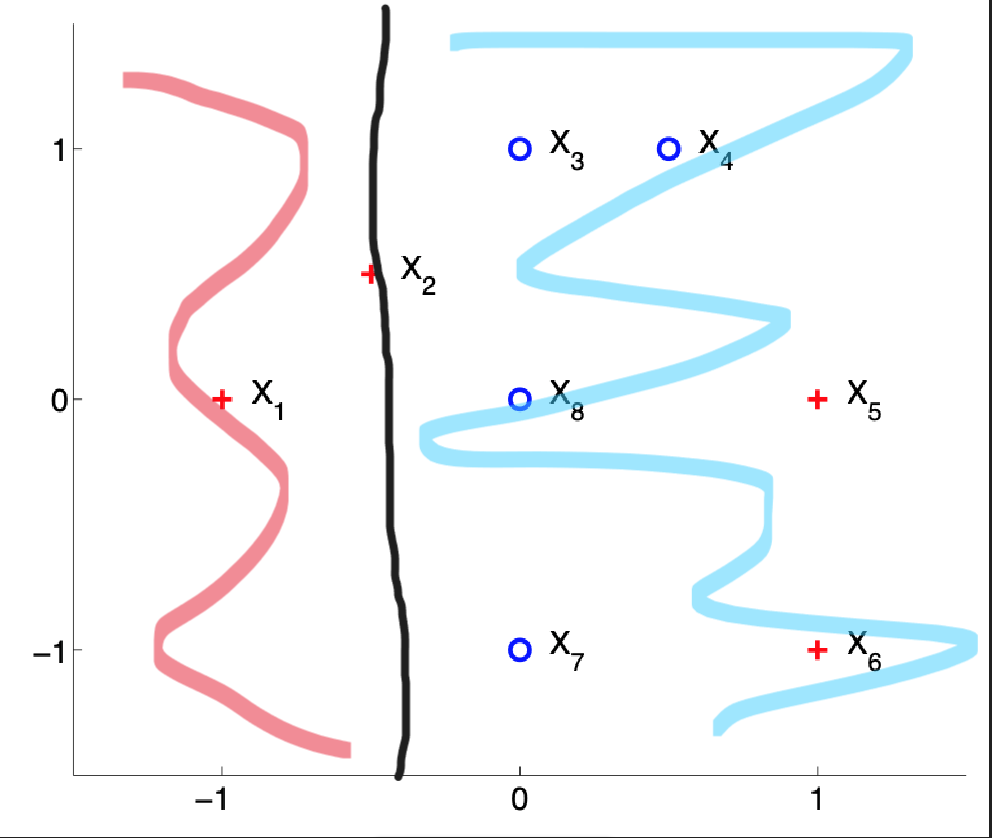

We thus achieve this split above (note: $X_2$ is included on the left space, or the "positively classified" space). 

Now, we can see that there are two points misclassified: $X_5$ and $X_6$. 

Thus, our error rate = $2*\frac{1}{8}$ = $\frac{2}{8}$.

That means we will want those error terms to have a higher weight. Before we can re-weight out points, however, we must solve for alpha, or the "say": 

$\alpha_1 = 0.5 ln(\frac{1-\epsilon_t}{\epsilon_t})$ = $\frac{1}{2} ln(\frac{1-\frac{2}{8}}{\frac{2}{8}})$ = $0.5493$

Now that we have solved for alpha, we can solve for the weights of each datapoint using the following equation:

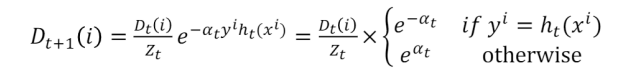

Which is a very complicated way to generalize a very easy process: For all points correctly classified, their new unnormalized weight is equal to their old weight times $e^{-\alpha}$. Then, for all points misclassified, their new unnormalized weight is equal to their old weight time $e^{\alpha}$

In this case, for all correctly classified points ($X_1, X_2, X_3, X_4, X_7, X_8$), their __unnormalized__ weights are equal to $\frac{1}{8} e^{-0.5493}$ = 0.072169

Then, for the misclassified points ($X_5, X_6$), their __unnormalized__ weights are equal to $\frac{1}{8} e^{0.5493}$ = 0.2165

To normalize these weights, we must add up all unnormalized weights, and divide each by this sum, to finally get the normalized weights: 

$(0.072169)*6 + (0.2165)*2$ = 0.866014

Thus, the final weights are 

- 0.072169/0.866014 = 0.08333 for $X_1, X_2, X_3, X_4, X_7, X_8$
- 0.2165/0.866014   = 0.25000 for $X_5, X_6$



## Iteration 2

Now, we must again solve for the WEIGHTED gini impurities (now the weight matters, as they are not all the same): I will make this write up brief, listing the values for each X and Y split: 

### Gini Impurities for X:

#### $x \leq -1$

true:  0.083/0 --> 0

false: 0.583/0.332 --> 0.46238

= __0.4239__

#### $x \leq -0.5$

true:  0.166/0 --> 0

false: 0.5/0.332 --> 0.47961

= __0.3998__

#### $x \leq 0$

true:  0.166/0.249 --> 0.48

false: 0.5/0.083 --> 0.244197

= __0.34225__

#### $x \leq 0.5$

true:  0.166/0.332 --> 0.4444

false: 0.5/0 --> 0 

= __0.22175__



### Gini Impurities for Y:

#### $y \leq -1$

true:  .25/.083 --> 0.37425

false: .416/.249 --> 0.46847

= __0.43703__


#### $y \leq 0$

true: .583/.166 --> 0.34502

false: .083/.166 --> 0.44444

= __0.36983__

#### $y \leq 0.5$

true: .666/.166 --> 0.31942

false: 0/.166 --> 0

= __0.26629__

In this case, we would go with the stump of $x \leq 0.5$, as it has the lowest constant. This works out just by nature of the math, but another choice could also be $y \leq 0.5$, as both of these choices correctly classify the two higher-weighted points, and misclassify 2 points in total.

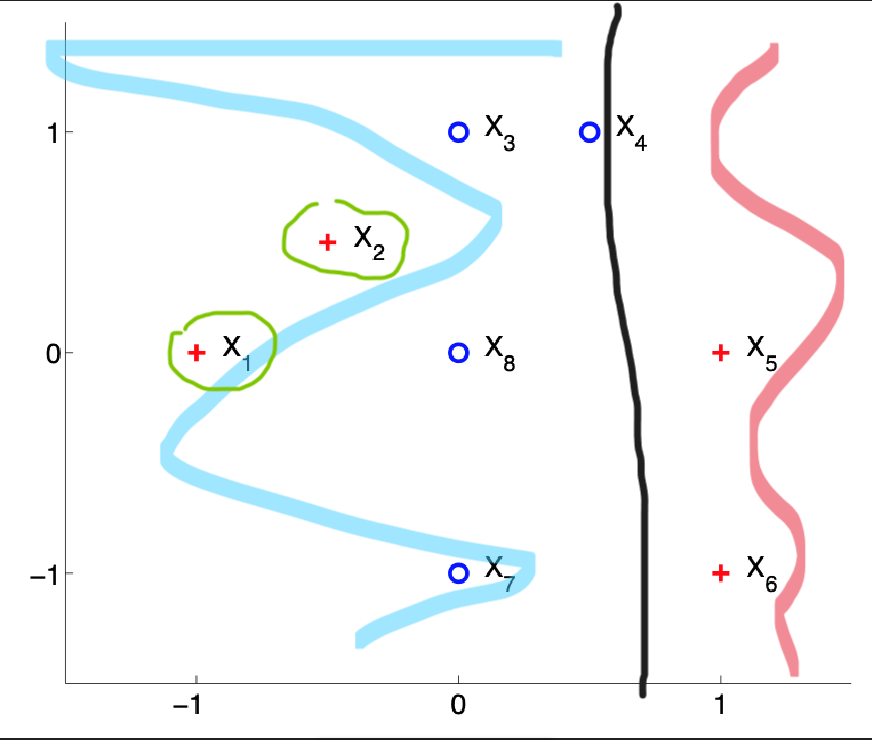

The error $\epsilon_2 = 0.08333*2$ = $0.16667$

alpha $a_2 = \frac{1}{2} ln(\frac{1-0.16667}{0.16667})$ = $0.80471$

With points 1 and 2 being misclassified,

UNNORMALIZED weights then equal: 

- $UW_1$ = $.083*e^{\alpha}$ = .1856
- $UW_2$ = $.083*e^{\alpha}$ = .1856
- $UW_3$ = $.083*e^{-\alpha}$ = .0371
- $UW_4$ = $.083*e^{-\alpha}$ = .0371
- $UW_5$ = $.25*e^{-\alpha}$ =  .1118
- $UW_6$ = $.25*e^{-\alpha}$ =  .1118
- $UW_7$ = $.083*e^{-\alpha}$ = .0371
- $UW_8$ = $.083*e^{-\alpha}$ = .0371

these sum to 0.7432, and thus the final normalized weights are:

- $W_1$ =  .1856/0.7432 = .24973
- $W_2$ =  .1856/0.7432 = .24973
- $W_3$ =  .0371/0.7432 = .04992
- $W_4$ =  .0371/0.7432 = .04992
- $W_5$ =  .1118/0.7432 = .15043
- $W_6$ =  .1118/0.7432 = .15043
- $W_7$ =  .0371/0.7432 = .04992
- $W_8$ =  .0371/0.7432 = .04992

## Iteration 3: One more time...

Solving for the last batch of Gini Impurities...

### Gini Impurities for X:

#### $x \leq -1$

true:  .25/0 --> 0

false: .55/.2 --> .391

= .29325

#### $x \leq -0.5$

true:  .5/0 --> 0

false: .3/.2 -->  .48

= .24

#### $x \leq 0$

true:  .5/.15 --> .355

false: .3/.05 --> .245

= .3165

#### $x \leq 0.5$

true:  .5/.2 --> .408

false: .3/0 --> 0

= .2856



### Gini Impurities for Y:

#### $y \leq -1$

true:  .15/.05 --> .375

false: .65/.15 --> .305

= .319


#### $y \leq 0$

true: .55/.1 --> .260

false: .25/.1 --> .408

= .3118

#### $y \leq 0.5$

true: .80/.1 --> .198

false: 0/.1 --> 0

=  .1782

Thus, we can see that $y \leq 0.5$ wins, and will become the split for our next (and final) stump.

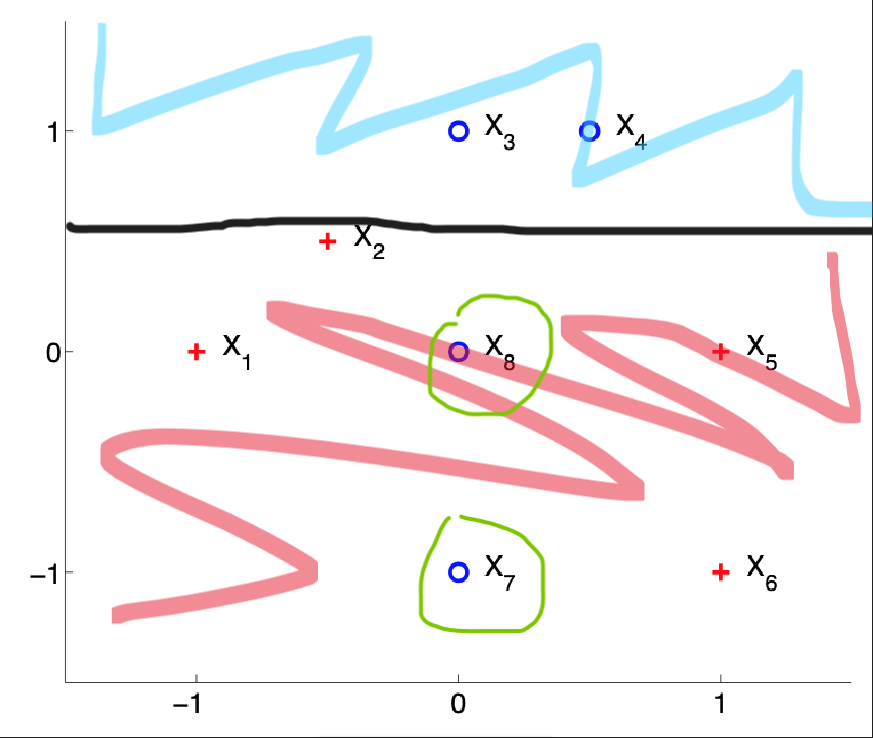

The error, $\epsilon = 2*.04992$ = $0.09984$

alpha, $a_3 = \frac{1}{2} ln(\frac{1-0.09984}{0.09984})$ = $1.0995$

Thus, the final UNNORMALIZED WEIGHTS would be:

- $UW_1$ = $.25*e^{-\alpha}$ = .0833
- $UW_2$ = $.25*e^{-\alpha}$ = .0833
- $UW_3$ = $.05*e^{-\alpha}$ = .0167
- $UW_4$ = $.05*e^{-\alpha}$ = .0167
- $UW_5$ = $.15*e^{-\alpha}$ = .0500
- $UW_6$ = $.15*e^{-\alpha}$ = .0500
- $UW_7$ = $.05*e^{\alpha}$ =  .1501
- $UW_8$ = $.05*e^{\alpha}$ =  .1501

Thus, Z = 0.6, and the final weights we'd use in iteration 4 if we were to continue, would be: 

- $W_1$ =  .0833/.6 = .1388
- $W_2$ =  .0833/.6 = .1388
- $W_3$ =  .0167/.6 = .0278
- $W_4$ =  .0167/.6 = .0278
- $W_5$ =  .0500/.6 = .0833
- $W_6$ =  .0500/.6 = .0833
- $W_7$ =  .1501/.6 = .2502
- $W_8$ =  .1501/.6 = .2502

## THE FINAL RESULT! 

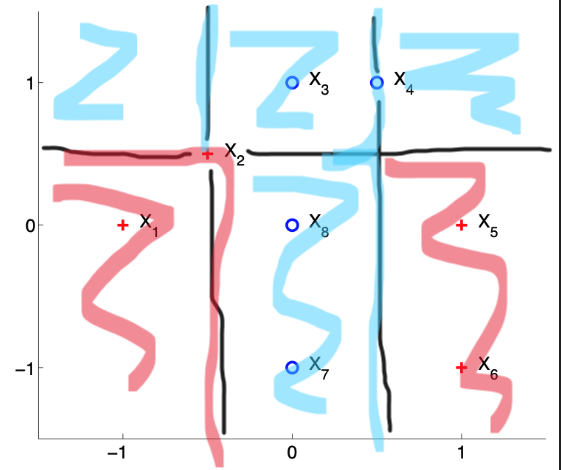

Here are the values asked for by the instructions, summarized:

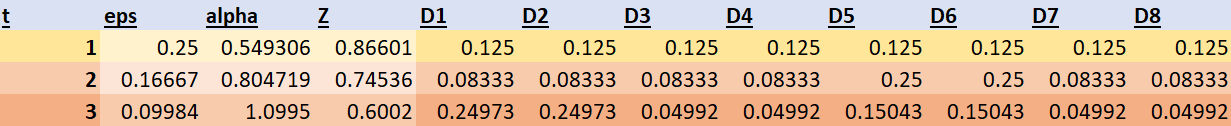

## Part B:

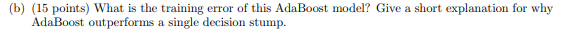

As can be seen above, the training error is 0! All training points get correctly placed in this AdaBoost model! 

It seems quite obvious why an AdaBoost model outperforms a single decision stump! Simply because an AdaBoost model has more stumps! AdaBoost creates a stump, sees where that one stump went wrong (weighs heavier on misclassified points), and taking into account the higher weight of the misclassified points (which happens via the math), it then creates another stump that tries to have the lowest weighted error, thus favoring those previously misclassified points. By doing so, after many iteratioins, it is able to create simply weak classifying stumps and use them together to create a very unique decision boundary made of simple stumps, and helps correctly classify points or groups of points that otherwise might have been hard to classify, which helps in situations in which decision boundaries are not simply linear, which, in the real world, is many cases.

This is much better than, well, one single stump... Because one stump is so much less sophisticated, and can only create one single straight hyperplane as a decision boundary.

# Problem 3: Random Forest, One-Class SVM: Email Spam [15 points]

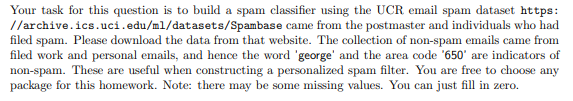

For this question, we will use a single-class SVM model with an RBF kernel to try to correctly classify non-spam emails. First, I load the data below:

In [2]:
df = pd.read_csv(r'data/spambase.data',header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


## Part A:

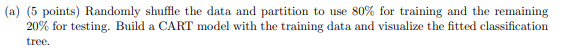

As the question asks, I take a random sample of all the indices in the dataset, which effectively "shuffles" the data. From there, I can simply split the data into train and test by using the first 80% of the now shuffled data as train data, and the remaining 20% as test data.

In [3]:
random.seed(20)
shuffle_indices = random.sample(range(len(df)),len(df))
data = df.iloc[shuffle_indices].reset_index(drop=True)
train = data.iloc[0:int(len(data)*.80),:]
test  = data.iloc[int(len(data)*.80):,:]

train_X = train.loc[:,0:56]
test_X  = test.loc[:,0:56]
train_y = train.loc[:,57]
test_y  = test.loc[:,57]

Next, as instructed, I create a Decision Tree Classifier (a type of CART model), fit it with the train data, and use it to predict the test data.

In [4]:
clf = tree.DecisionTreeClassifier(random_state=1993)
clf.fit(train_X,train_y)
clf_preds = clf.predict(test_X)
clf_acc = accuracy_score(test_y,clf_preds)

Finally, I can plot the decision tree, which shows each node and leaf, and the gini coefficient that won the split variable and value. Note that, if I try to plot the whole tree, it does not show, as it is way too big to fit onto a long,skinny workspace. Thus, I plot only with a max depth of 5, to see the basic structure of the tree.

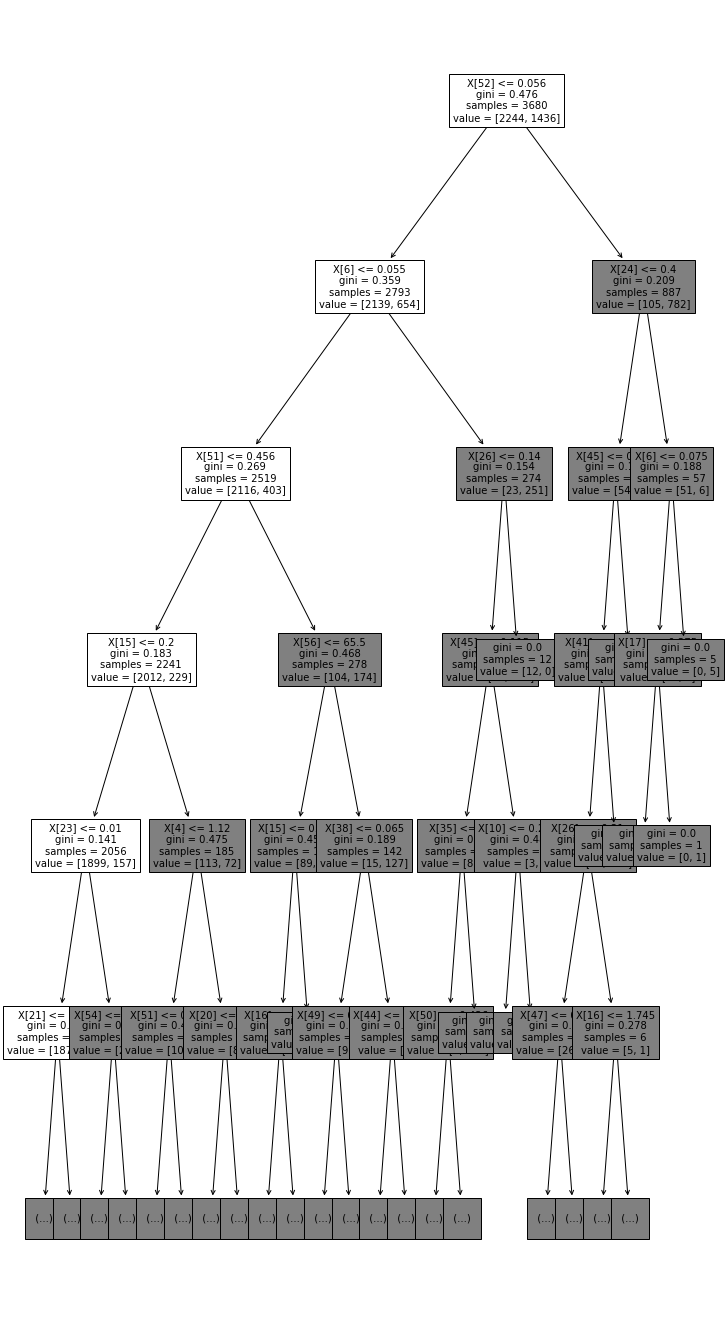

In [5]:
plt.figure(figsize=(12,24))
tree.plot_tree(clf,fontsize=10,max_depth=5)
plt.show()

We can see that, at certain levels, the tree forms a leaf, with only one side of a split branching further down. 

## Part B: 

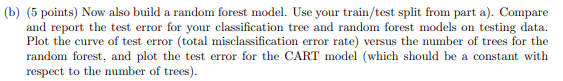

Now, I will build a random forest model, as instructed. 

In [6]:
rf = ensemble.RandomForestClassifier(random_state=1993)
rf.fit(train_X,train_y)
rf_preds = rf.predict(test_X)
rf_acc = accuracy_score(test_y,rf_preds)

After building, fitting, and predicting using the random forest model, I can compare the accuracy of the random forest model with the basic CART model above:

In [7]:
print(f"The error of the Decision Tree Classifier Model was {round(100-clf_acc*100,2)}%")
print(f"Whereas the error of the Random Forest Classifier was {round(100-rf_acc*100,2)}%")

The error of the Decision Tree Classifier Model was 9.55%
Whereas the error of the Random Forest Classifier was 5.1%


As can be seen, and to be expected, the random forest performed better! The main parameter to tune when creating a random forest model is the number of trees. As instructed, I can create, fit, and predict in the same way, using a range of trees, to see how each model with each value of trees compares. We can do so to track at which value of trees the error is the lowest, or when the decrease in error starts to plateau. And finally, I will plot the error of the basic tree model as comparison.

In [8]:
error_tracker = pd.DataFrame(columns=['number_trees','error'])
for i in range(1,100,1):
    q = ensemble.RandomForestClassifier(random_state=1993,n_estimators = i)
    q.fit(train_X,train_y)
    p = q.predict(test_X)
    e = 1-accuracy_score(test_y,p)
    error_tracker.loc[len(error_tracker)] = (i,e)

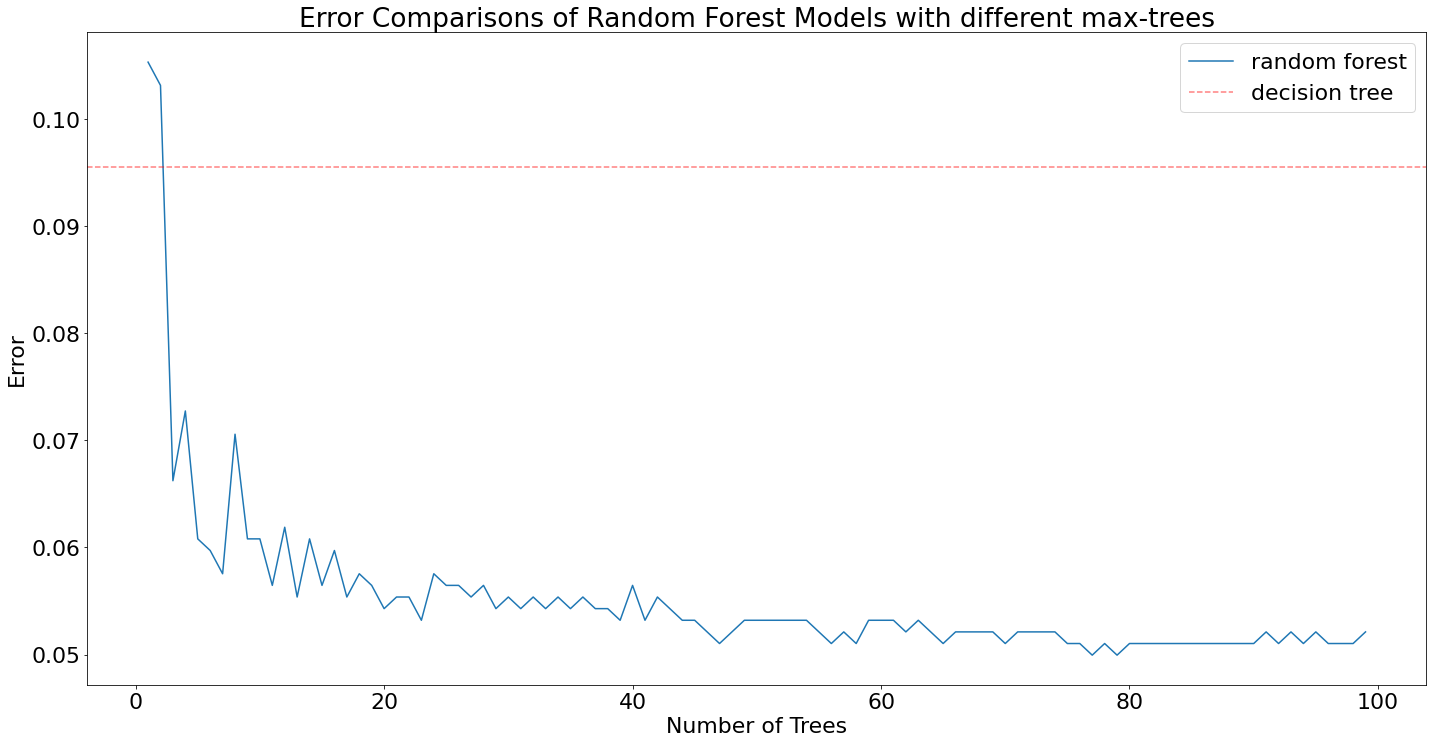

In [9]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(24,12))
plt.plot(error_tracker['number_trees'],error_tracker['error'],label='random forest')
plt.axhline(1-clf_acc,c='r',linestyle='--',alpha=0.5,label='decision tree')
plt.title('Error Comparisons of Random Forest Models with different max-trees')
plt.xlabel('Number of Trees')
plt.ylabel('Error')
plt.legend()
plt.show()
plt.rcParams.update({'font.size': 10})

As can be seen, the random forest already performs extremely well with just a few trees, with error decrease starting to plateau already at 25 trees. By 75 trees, there is virtually no difference in error. Finally, we can see that already from the start, a basic random forest model with just a few trees already outperforms the basic model (red dashed line).

## Part C: 

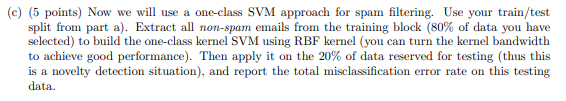

To do so, first, I have to filter out the NON-spam emails from my training set, train_x, which I can do by filtering train_y for just the values ==0, and use those indexes to slice train_x, and create a new dataframe. 

In [10]:
non_spam_train_X = train_X.iloc[list(train_y[train_y==0].index)]

Then, I can create a basic OneClassSVM model with 'rbf' kernel as instructed, and see how well it performs! 

Some things to note: We are filtering out our one single class, which the one-class SVM trains on, and fits a model on. Then, when we pass in another dataset, the one-class SVM acts as an anomaly detection program, in which, in the test set, it marks points that it finds to be on the right side of the decision boundary as a "1", which identifies it as NOT an anomaly. Then, it marks points as -1 for points it determines an anomaly! In our case, since, in reality, we had 2 classes, those -1 marks will be referring (hopefully) to spam emails! 

Thus, at the end, we have to make sure to change the labels before checking the misclassification rate, in which we change the -1s to 1s (as spam emails are marked as 1 in our original dataset, and non-spam, 0!), but since we are training on the 0-class, any points it classifies as being in the same class will be noted with a "1", thus the reaosn we have to change the labels. 

In [11]:
svc = OneClassSVM(kernel='rbf')
svc.fit(non_spam_train_X)
oneclass_preds = svc.predict(test_X)
oneclass_preds = [1 if i == -1 else 0 for i in oneclass_preds]
print(f"Total Misclassification Error Rate: {100 - round(accuracy_score(test_y,oneclass_preds)*100,2)}%")

Total Misclassification Error Rate: 43.87%


As we can see, a basic out-of-the-box model does not do so well! This might look discouraging, but we can actually tune gamma to get that misclassification rate lower! 

In [12]:
params = {'gamma':(.01,.02,.05,.1)}
cv = GridSearchCV(OneClassSVM(kernel='rbf'),params,scoring='accuracy')
cv.fit(non_spam_train_X,[0]*len(non_spam_train_X))

GridSearchCV(estimator=OneClassSVM(),
             param_grid={'gamma': (0.01, 0.02, 0.05, 0.1)}, scoring='accuracy')

In [13]:
cv.best_estimator_

OneClassSVM(gamma=0.01)

As can be seen, the Cross-Validation Grid Search algorithm finds gamma=0.01 to have the best results. Thus, I will re-perform the process above using gamma=0.01:

In [14]:
svc = OneClassSVM(kernel='rbf',gamma=.01)
svc.fit(non_spam_train_X)
oneclass_preds = svc.predict(test_X)
oneclass_preds = [1 if i == -1 else 0 for i in oneclass_preds]
print(f"Total Misclassification Error Rate: {round(100 - round(accuracy_score(test_y,oneclass_preds)*100,2),2)}%")

Total Misclassification Error Rate: 31.27%


As we can see, this is much better! Now our misclassification rate is only 31-36%, depending on the shuffle of the train and test data. This might still be high, but It's what we expect given the data we have! 

# Problem 4: Locally Weighted Linear Regression, Bias-Variance [35 points]

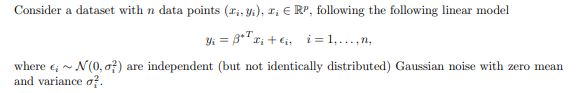

## Part A:

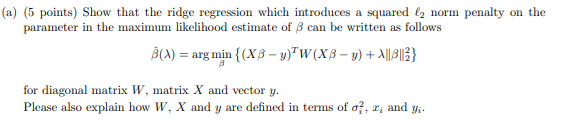

Given our function of y, including the error term whose values are normally distributed with mean 0, and variance of $\sigma^2$, and are independent but NOT identically distributed, 

we can take the log-likelihood as the following: 

First, we want to write out the expanded version of the problem, by using the log: 

$\Sigma^n_{i=1} log f(y_i | \beta)$ = $\Sigma^n_{i=1} log \frac{1}{(2\pi) \sigma_i^2} e^{-\frac{(y_i - \beta^T x_i)}{2\sigma_i^2}}$ 

= $\Sigma^n_{i=1} -\frac{1}{2} log(2\pi \sigma^2_i) - \Sigma^n_{i=1} \frac{(y_i - \beta x_i)^2}{2\sigma^2_i}$

Next, we want to create the Maximum-Likelihood Estimator. To do so, we create an optimization problem in which we maximize the likelihood function. While MLE uses a max function traditionally, a max f(x) problem is the same as a min -f(x) problem. 

NOTE, this next equation only considers pieces of our function above that include a beta term, as this is the term we are minimizing with respect to. Thus, we can ignore the first term, $\Sigma^n_{i=1} -\frac{1}{2} log(2\pi \sigma^2_i)$, as it does not contribute to the minimization problem at hand, and goes away anyway when taking the derivative with respect to beta.

Also note, that, as mentioned, the sign changes due to changing a max problem to a min problem. 

Finally, as we are solving MLE for **RIDGE** regression, and not the standard regression problem, we need to include a lagrangian multiplier, which acts as a punishment term for large sums of squares of the beta coefficients, by definition of ridge regression. This term is written as $||\beta||_2^2$

min $\beta$ of $\Sigma^n_{i=1} \frac{(y_i - \beta x_i)^2}{2\sigma^2_i} + \lambda || \beta ||^2_2$

Then, to get from this step to our final equation, we simply separate the fraction into its two components: 

- $(y_i - \beta x_i)^2$ , which in matrix form, is written as $(y_i - \beta X_i)^T (y_i - \beta X_i)$ 
- $\frac{1}{2\sigma_i^2}$

Finally, we can create a variable to represent the $\frac{1}{2\sigma_i^2}$, which we will denote as W. Due to the order in which the matrices must be multiplied, this W term must go in the middle of our squared term, as W will be a diagonal matrix of $\frac{1}{2\sigma_i^2}$ with its rows equaling the amount of columns in the transpose term, and the columns equaling the amount of rows in the final term. Finally, since the top term is squared, the order of subtraction becomes irrelevant.

Thus, our final equation is that which we are shown in the question: 

**Min $(X\beta - y)^T W (X\beta - y) + \lambda||\beta||^2_2$**

-----------------------------------

In this case, again, 

- W is a diagonal matrix representing $\frac{1}{2\sigma_i^2}$
- X is a vector of $x_i$ values, which serve as the training data
- Y is a vector of $y_i$, which represent the outcome variables of the training set.

## Part B: 



Given that we have the final function: 

$\hat \beta(\lambda) = $ argmin $(X\beta-y)^T W (X\beta - y) + \lambda ||\beta||^2_2$

We can solve the closed-form solution for $\hat \beta(\lambda)$ by using the derivative to solve for argmin, and setting equal to 0. Thus, we get the following steps: 

- First, multiplying out the parenthases: $(X\beta W - yW) (X\beta - y) + \lambda ||\beta||_2^2$
- Next: $X\beta W X\beta - X\beta Wy -yWX\beta + yWy + \lambda ||\beta||_2^2 $
- Then, we can take the derivative in regard to $\beta$: $2\cdot X^TWX\beta - XWy - yWX + 2\lambda||\beta|| = 0$
- Simplifying, we get: $2(XWX\beta - XWy + \lambda\beta) = 0$
- Then, we can get rid of the 2 and move isolate the beta on the RHS, and we are left with $\frac{X^T W y}{X^T W X + \lambda I} = \beta$,which we can write in correct matrix format as 

$(X^T W X + \lambda I)^{-1} (X^T W y) = \beta$

Notice that the lambda term is multiplied by the identity matrix one the beta disappears when taking the derivative, to keep its matrix form, since lambda is a scalar.

----------------

Next, we are asked to define the distribution of $\hat \beta (\lambda)$. 

If we take beta to have a gaussian distribution, then the mean will equal the expectation of $\beta(\lambda)$. Thus, going step by step: 

- $E[\beta(\lambda)] = E[X^T W y (X^T W X + \lambda I)^{-1})]$ = 
- $X^T W E[y](X^T W X + \lambda I)^{-1}$ = 

$X^T W X \beta (X^T W X + \lambda I)^{-1}$ = $\mu$, since y is normally distributed with mean $X\beta$* and variance as a diagonal matrix of $\sigma_i^2$ 

Then, The Variance of $\beta(\lambda)$:

$Var[\beta(\lambda))]$ = $E[(x^T \hat \beta)^2] - (E[x^T \hat \beta])^2$ = $Var[X^T W y (X^T W X + \lambda I)^{-1})]$ = 


$(X^T W X + \lambda I)^{-1} X^T W X ((X^T W X + \lambda I)^{-1})^T$

Thus, in conclusion, the distribution of $\beta(\lambda)$ is 

$\beta (\lambda)$ ~ $N(X^T W X \beta$* $(X^T W X + \lambda I)^{-1},(X^T W X + \lambda I)^{-1} X^T W X ((X^T W X + \lambda I)^{-1})^T)$

## Part C:



In lecture, we are given the following equation for bias: 

Bias = $E_x[E_D[\hat f(x)] - h(x)]$,

with 

- $\hat f(x)$ as the ACTUAL predictor, 
- $E_D[\hat f(x)]$ as the EXPECTED predictor, 
- h(x) = the OPTIMAL predictor

In other words, bias measures how far the predictions on the training dataset are from the true outcomes, and describes how well the model matches the training data.


To determine the expected predictor, then, we can take our expectation for Beta (which we derived above, and will equal the mean of beta's distribution) multiplied by x. The OPTIMAL predictor thus will be the optimal beta value * x. Thus, both of these will be a scalar, and their difference will be equal to the bias. 

Remember that our expected value for beta is the mean of beta's distribution, which is equivalent to $X^T W X \beta^* (X^T W X + \lambda I)^{-1}$.

Thus, 

- $E_D[\hat f(x)]$ = $X^T W X \beta$* $(X^T W X + \lambda I)^{-1} x$
- $h(x)$ = $\beta^*x$

Thus, **bias = $X^T W X \beta^* (X^T W X + \lambda I)^{-1} x$ - $\beta^*x$**

## Part D: 



See the majority of the derivation for the variance of $\beta(\lambda)$ above in part B! Now, we are asked to derive the variance term as a function of $\lambda$ and some fixed point "x". 

Thus, we can simply implement the following, given what we know about Variance = $E[(x^T \hat \beta)^2] - (E[x^T \hat \beta])^2$:

$Var[x^T \beta(\lambda)] = x^T Var[\beta(\lambda)] x$ = 


$x^T(X^T W X + \lambda I)^{-1} X^T W X ((X^T W X + \lambda I)^{-1})^T )x$

Notice the difference between the little x, which is the test point, and the vector big-X, which is filled with the training points.

## Part E: 

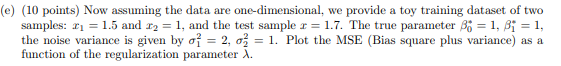

In [15]:
x = np.array([[1,1.7]])
X = np.array([[1,1.5],[1,1]])
B = np.array([[1,1]])
W = np.array([[1/(2*2),0],[0,1/(2*1)]])

bias = []
for L in np.arange(0,3,.01):
    bias.append(((X.T@W@X@B.T).T@np.linalg.inv(X.T@W@X + L*np.eye(2))@x.T - B@x.T)[0,0])
bias_2 = [i**2 for i in bias]

var = []
for L in np.arange(0,3,.01):
    var.append(((x@np.linalg.inv((X.T@W@X + L*np.eye(2))))@X.T@W@X@np.linalg.inv((X.T@W@X + L*np.eye(2)))@x.T)[0,0])
    
MSE = [i+j for i, j in zip(bias_2,var)]

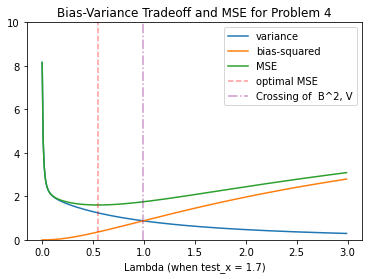

In [16]:
sns.lineplot(x=np.arange(0,3,0.01),y=var,label='variance')
sns.lineplot(x=np.arange(0,3,0.01),y=bias_2,label='bias-squared')
sns.lineplot(x=np.arange(0,3,0.01),y=MSE,label='MSE')
plt.axvline(x=0.55,c='r',linestyle='--',alpha=0.4,label='optimal MSE')
plt.axvline(x=0.99,c='purple',linestyle='-.',alpha=0.4,label='Crossing of  B^2, V')
plt.title('Bias-Variance Tradeoff and MSE for Problem 4')
plt.xlabel('Lambda (when test_x = 1.7)')
plt.ylim(0,10)
plt.legend()
plt.show()

In [17]:
print(f"The crossing-point of bias-squared and variance is: Lambda={.99}. The optimal MSE occurs when Lambda = {MSE.index(min(MSE))*.01}")
print(f"The minimum MSE is: {round(min(MSE),2)}")

The crossing-point of bias-squared and variance is: Lambda=0.99. The optimal MSE occurs when Lambda = 0.55
The minimum MSE is: 1.61


## Part F:

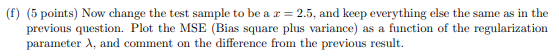

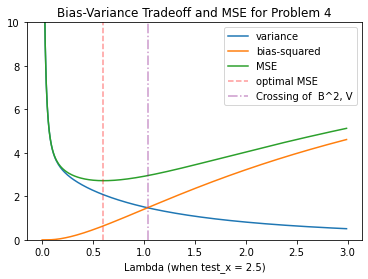

In [18]:
x = np.array([[1,2.5]])
X = np.array([[1,1.5],[1,1]])
B = np.array([[1,1]])
W = np.array([[1/(2*2),0],[0,1/(2*1)]])

bias = []
for L in np.arange(0,3,.01):
    bias.append(((X.T@W@X@B.T).T@np.linalg.inv(X.T@W@X + L*np.eye(2))@x.T - B@x.T)[0,0])
bias_2 = [i**2 for i in bias]

var = []
for L in np.arange(0,3,.01):
    var.append(((x@np.linalg.inv((X.T@W@X + L*np.eye(2))))@X.T@W@X@np.linalg.inv((X.T@W@X + L*np.eye(2)))@x.T)[0,0])

MSE = [i+j for i, j in zip(bias_2,var)]

sns.lineplot(x=np.arange(0,3,0.01),y=var,label='variance')
sns.lineplot(x=np.arange(0,3,0.01),y=bias_2,label='bias-squared')
sns.lineplot(x=np.arange(0,3,0.01),y=MSE,label='MSE')
plt.axvline(x=0.6,c='r',linestyle='--',alpha=0.4,label='optimal MSE')
plt.axvline(x=1.035,c='purple',linestyle='-.',alpha=0.4,label='Crossing of  B^2, V')
plt.title('Bias-Variance Tradeoff and MSE for Problem 4')
plt.xlabel('Lambda (when test_x = 2.5)')
plt.ylim((0,10))
plt.legend()
plt.show()

In [19]:
print(f"The crossing-point of bias-squared and variance is: Lambda={1.04}. The optimal MSE occurs when Lambda = {MSE.index(min(MSE))*.01}")
print(f"The minimum MSE is: {round(min(MSE),2)}")

The crossing-point of bias-squared and variance is: Lambda=1.04. The optimal MSE occurs when Lambda = 0.6
The minimum MSE is: 2.72


As can be seen, with a bigger test point (from 1.7 to 2.5), the optimal MSE shifts ever so slightly to the right, at lambda = 0.6 (a shift of .05, as the optimal Lambda for MSE when x-test = 1.7 was 0.55). Note that this shift, due to significant figures, is indiscernible from 0.6, as all our math has significant figures up to the first decimal. 

That being said, the actual minimum MSE value has shifted up. Also, while hard to notice with such a small change from 1.7 to 2.5, the curves all got slightly more separated, with wider margins between the variance and the bias_squared at the extreme ends, meaning that all error has slightly gone up, and increases more at the extremes. 